In [162]:
%load_ext autoreload
import sys
sys.path.append('../.')
from cppn import *
from util import visualize_network
import numpy as np
import torch
import matplotlib.pyplot as plt
import imageio as iio

%matplotlib inline

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [163]:
latent_dim = 0

In [164]:
from activation_functions import *
net = CPPN()
net.config.use_radial_distance = False
net.config.use_input_bias = True
net.config.num_extra_inputs = latent_dim
net.config.res_h=32
net.config.res_w=30
net.config.activations = [sin, relu]
net.reconfig()

for _ in range(20):
    net.mutate()

In [165]:
# latent = (res_h, res_w, latent_dim)
latent = torch.FloatTensor(latent_dim).uniform_(-1.0, 1.0).repeat(net.config.res_h, net.config.res_w, 1)

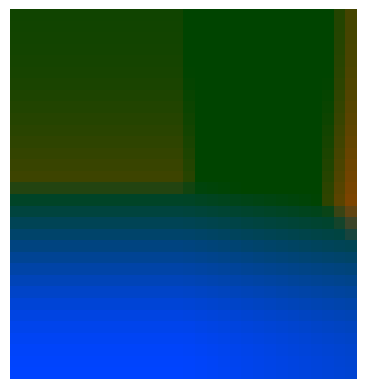

In [166]:
img = net.get_image(extra_inputs=latent)
plt.imshow(img)
plt.axis('off');

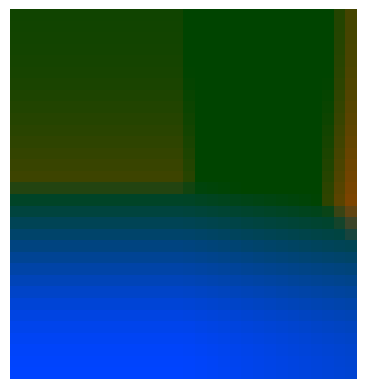

In [167]:
mutation = torch.FloatTensor(latent_dim).uniform_(-1,1).repeat(net.config.res_h, net.config.res_w, 1) * 0.1
img = net.get_image(extra_inputs=latent+ mutation)
plt.imshow(img)
plt.axis('off');

In [168]:
imgs = []
num = 0
for _ in range(num):
    mutation = torch.FloatTensor(latent_dim).uniform_(-1,1).repeat(net.config.res_h, net.config.res_w, 1) * 0.01
    latent = latent + mutation
    img = net.get_image(extra_inputs=latent)
    img = img * 255
    img = img.numpy().astype(np.uint8)
    imgs.append(img)
if num >0:
    # make gif  
    iio.mimsave('latent_exploration.gif', imgs, duration=0.1)

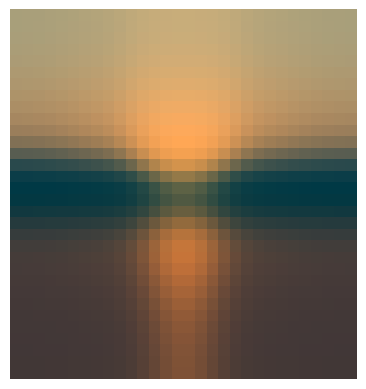

In [170]:
with open("sunrise.json") as f:
    net_json = json.load(f)
    net = CPPN.create_from_json(net_json, configClass=Config)
img = net.get_image()
plt.imshow(img); plt.axis('off'); plt.show()
net.prepare_optimizer(lr=.001)



In [174]:
target=torch.tensor(iio.imread('../../data/sunrise/sunrise.png'), dtype=torch.float32) / 255.0
net.config.res_h, net.config.res_w = target.shape[:2]
net.reconfig()
print(target.shape)

torch.Size([342, 319, 3])


In [175]:
from functorch.compile import compiled_function, draw_graph, aot_function

def f(x):
    return net.get_image_data_parallel(extra_inputs=x) 
    
def fw(f, inps):
    # draw_graph(f, "forward.svg")
    # print(f)
    return f
 
def bw(f, inps):
    # draw_graph(f, "backward.svg")
    return f
    
aot_fn = aot_function(f, fw_compiler=fw, bw_compiler=bw)
# img = aot_fn(latent)
# draw_graph(aot_fn, "net.svg")

In [176]:
# plt.imshow(img.detach()); plt.axis('off'); plt.show()
from fitness_functions import *

# loss_fn = torch.nn.MSELoss()
# loss_fn = lambda x,y: 1.0-haarpsi(x,y) 
loss_fn = lambda x,y: 1.0-mse(x,y,keep_grad=True)

imgs = []
from tqdm import trange
pbar = trange(10000)
for _ in pbar:
    
    img = aot_fn(latent)
    imgs.append(img.detach().numpy())
    img, target = correct_dims(img.unsqueeze(0), target)
    # print("Before: ", list(net.connection_genome.values())[0].weight)
    
    net.optimizer.zero_grad()
    loss = loss_fn(img, target)
    loss.backward()
    net.optimizer.step()
    # print("After: ", list(net.connection_genome.values())[0].weight)
    # plt.imshow(img.detach()); plt.axis('off'); plt.show()
    pbar.set_description(f"Loss: {loss.item():.4f}")



  0%|          | 0/10000 [25:06<?, ?it/s]


KeyboardInterrupt: 

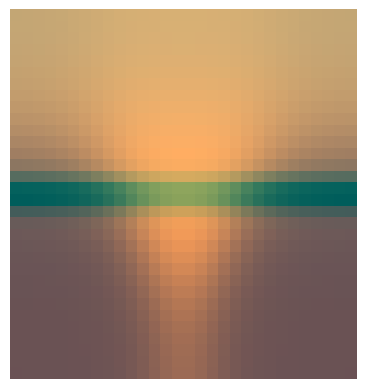

In [ ]:
output = imgs[-1]
plt.imshow(output); plt.axis('off'); plt.show()

In [ ]:
# save gif
imgs = [img * 255 for img in imgs]
imgs = [img.astype(np.uint8) for img in imgs] 
iio.mimsave('backprop.gif', imgs, duration=0.1)